In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

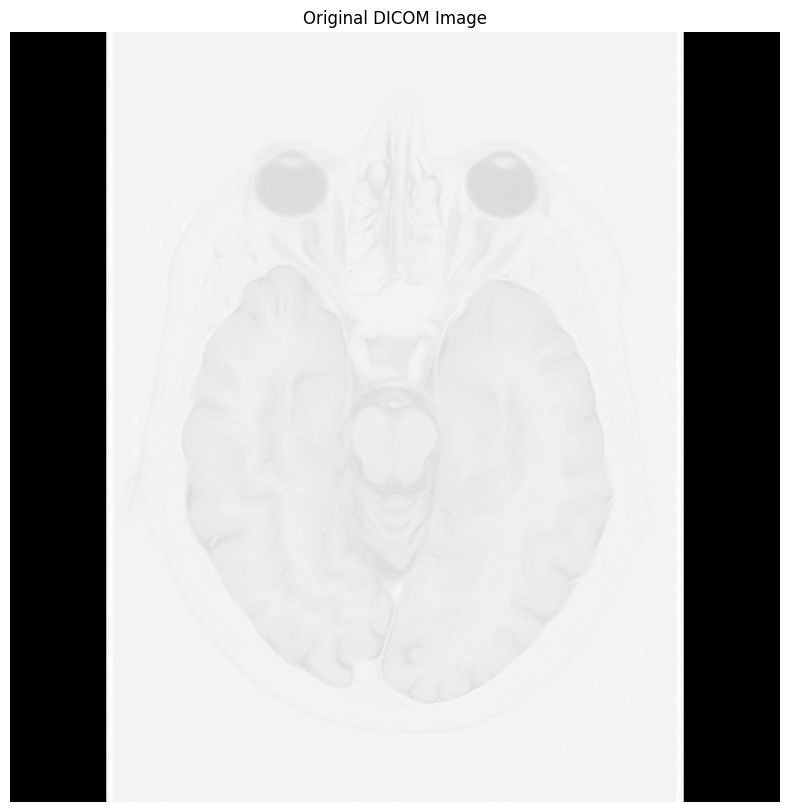

In [2]:
def load_dicom_image(filepath):
    """
    Load a DICOM image and return both the dataset and pixel array
    """
    # Load the DICOM dataset
    ds = pydicom.dcmread(filepath)
    
    # Get pixel array
    pixel_array = ds.pixel_array
    
    return ds, pixel_array

# Load example image
ds, image = load_dicom_image('m2_images/brain.dcm')

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title('Original DICOM Image')
plt.axis('off')
plt.show()

In [3]:
def print_dicom_metadata(ds):
    """
    Print important DICOM metadata fields
    """
    important_fields = [
        'PatientName',
        'PatientID',
        'StudyDate',
        'Modality',
        'ManufacturerModelName',
        'PixelSpacing',
        'ImagePosition',
        'WindowCenter',
        'WindowWidth',
        'BitsStored'
    ]
    
    print("Important DICOM Metadata:")
    print("-" * 40)
    
    for field in important_fields:
        if hasattr(ds, field):
            print(f"{field}: {getattr(ds, field)}")
        else:
            print(f"{field}: Not available")

# Print metadata
print_dicom_metadata(ds)

# Get image-specific information
print("\nImage Properties:")
print(f"Image Shape: {image.shape}")
print(f"Data Type: {image.dtype}")
print(f"Value Range: [{np.min(image)}, {np.max(image)}]")

Important DICOM Metadata:
----------------------------------------
PatientName: MR/BRAIN/GRASE/1024
PatientID: 7
StudyDate: 19950330
Modality: MR
ManufacturerModelName: T5
PixelSpacing: [0.488281, 0.488281]
ImagePosition: Not available
WindowCenter: 1951
WindowWidth: 237
BitsStored: 12

Image Properties:
Image Shape: (512, 512)
Data Type: uint16
Value Range: [0, 2150]


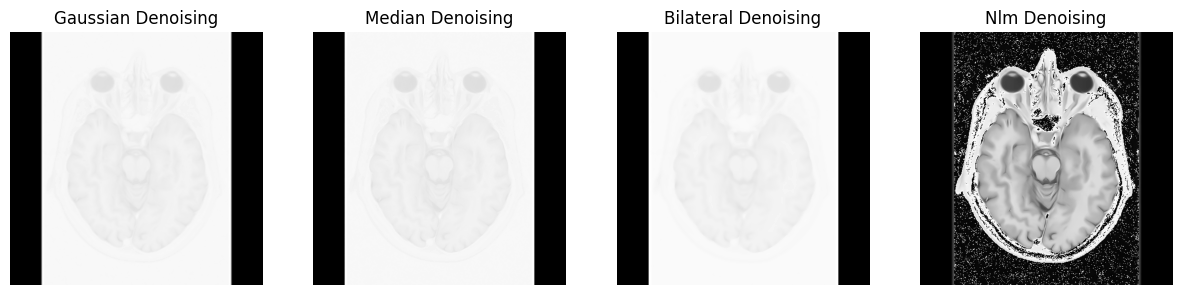

In [4]:
def apply_noise_reduction(image, method='gaussian', params=None):
    """
    Apply different noise reduction methods suitable for medical images
    
    Parameters:
    image: Input image array
    method: 'gaussian', 'median', 'bilateral', or 'nlm' (Non-local means)
    params: Dictionary of method-specific parameters
    """
    if params is None:
        params = {}
    
    if method == 'gaussian':
        sigma = params.get('sigma', 1.0)
        return ndimage.gaussian_filter(image, sigma)
    
    elif method == 'median':
        size = params.get('size', 3)
        return ndimage.median_filter(image, size)
    
    elif method == 'bilateral':
        d = params.get('d', 9)
        sigmaColor = params.get('sigmaColor', 75)
        sigmaSpace = params.get('sigmaSpace', 75)
        return cv2.bilateralFilter(image.astype(np.float32), d, sigmaColor, sigmaSpace)
    
    elif method == 'nlm':
        h = params.get('h', 10)
        templateWindowSize = params.get('templateWindowSize', 7)
        searchWindowSize = params.get('searchWindowSize', 21)
        return cv2.fastNlMeansDenoising(
            image.astype(np.uint8), 
            h=h,
            templateWindowSize=templateWindowSize,
            searchWindowSize=searchWindowSize
        )

# Apply different noise reduction methods
methods = ['gaussian', 'median', 'bilateral', 'nlm']
denoised_images = {}

for method in methods:
    denoised_images[method] = apply_noise_reduction(image, method)

# Display results
plt.figure(figsize=(15, 5))
for i, (method, processed) in enumerate(denoised_images.items(), 1):
    plt.subplot(1, 4, i)
    plt.imshow(processed, cmap='gray')
    plt.title(f'{method.capitalize()} Denoising')
    plt.axis('off')
plt.show()

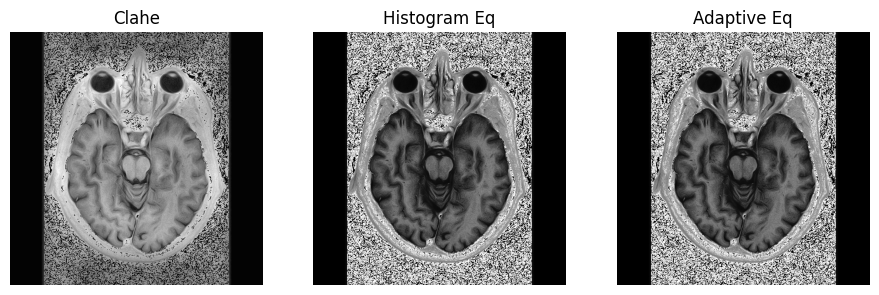

In [45]:
def enhance_contrast(image, method='clahe', params=None):
    """
    Apply different contrast enhancement methods suitable for medical images
    
    Parameters:
    image: Input image array
    method: 'clahe', 'histogram_eq', 'window_level', or 'adaptive_eq'
    params: Dictionary of method-specific parameters
    clahe: Contrast Limited Adaptive Histogram Equalization
    """
    if params is None:
        params = {}
    
    # Normalize image to 0-255 range
    image_norm = ((image - np.min(image)) * 255 / 
                 (np.max(image) - np.min(image))).astype(np.uint8)
    
    if method == 'clahe':
        clipLimit = params.get('clipLimit', 2.0)
        tileGridSize = params.get('tileGridSize', (8, 8))
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        return clahe.apply(image_norm)
    
    elif method == 'histogram_eq':
        return cv2.equalizeHist(image_norm)
    
    
    elif method == 'adaptive_eq':
        return cv2.equalizeHist(image_norm)

# Apply different contrast enhancement methods
enhancement_methods = ['clahe', 'histogram_eq',  'adaptive_eq']
enhanced_images = {}

for method in enhancement_methods:
    enhanced_images[method] = enhance_contrast(image, method)

# Display results
plt.figure(figsize=(15, 5))
for i, (method, processed) in enumerate(enhanced_images.items(), 1):
    plt.subplot(1, 4, i)
    plt.imshow(processed, cmap='gray')
    plt.title(f'{method.replace("_", " ").title()}')
    plt.axis('off')
plt.show()

Important DICOM Metadata:
----------------------------------------
PatientName: MR/BRAIN/GRASE/1024
PatientID: 7
StudyDate: 19950330
Modality: MR
ManufacturerModelName: T5
PixelSpacing: [0.488281, 0.488281]
ImagePosition: Not available
WindowCenter: 1951
WindowWidth: 237
BitsStored: 12


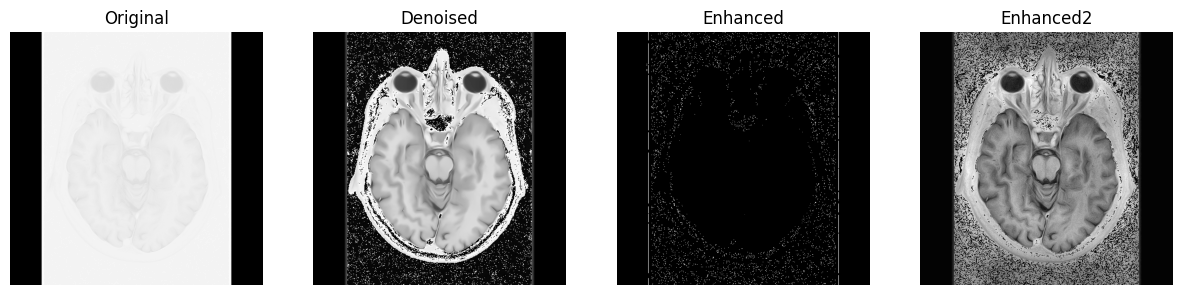

In [40]:
def dicom_processing_pipeline(filepath, denoise_params=None, enhance_params=None):
    """
    Complete processing pipeline for DICOM images
    """
    # Load image
    ds, image = load_dicom_image(filepath)
    
    # Print metadata
    print_dicom_metadata(ds)
    
    # Apply noise reduction
    denoised = apply_noise_reduction(
        image, 
        method='nlm',  # Non-local means often works well for medical images
        params=denoise_params
    )
    
    # Apply contrast enhancement
    enhanced = enhance_contrast(
        denoised,
        method='clahe',  # CLAHE is often preferred for medical images
        params=enhance_params
    )
    
     # Apply contrast enhancement
    enhanced2 = enhance_contrast(
        image,
        method='clahe',  # CLAHE is often preferred for medical images
        params=enhance_params
    )
    
    # Display original and processed images
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(denoised, cmap='gray')
    axes[1].set_title('Denoised')
    axes[1].axis('off')
    
    axes[2].imshow(enhanced, cmap='gray')
    axes[2].set_title('Enhanced')
    axes[2].axis('off')
    
    axes[3].imshow(enhanced2, cmap='gray')
    axes[3].set_title('Enhanced2')
    axes[3].axis('off')
    
    plt.show()
    
    return enhanced

# Example usage
processed_image = dicom_processing_pipeline(
    'm2_images/brain.dcm',
    denoise_params={'h': 10},
    enhance_params={'clipLimit': 2.0, 'tileGridSize': (8, 8)}
)


OpenCV Info:
Image shape: (940, 934)
Data type: uint8


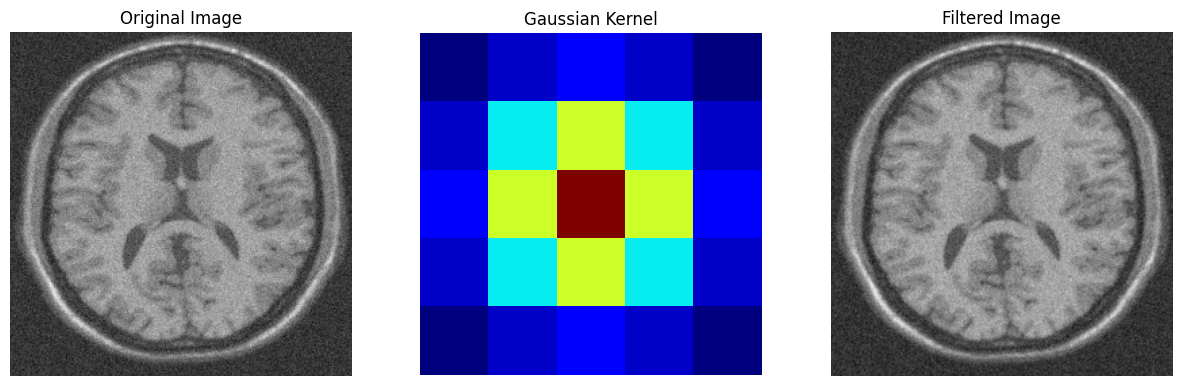

array([[64, 58, 49, ..., 39, 39, 39],
       [64, 58, 49, ..., 39, 39, 39],
       [62, 57, 48, ..., 39, 39, 38],
       ...,
       [57, 59, 61, ..., 56, 52, 50],
       [58, 58, 59, ..., 47, 47, 47],
       [58, 58, 59, ..., 43, 44, 45]], dtype=uint8)

In [41]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def load_and_prepare_image(image_path):
    """
    Load and prepare the image for processing
    """
    try:
        # Read image
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        if image is not None:
            # Print basic information
            print("\nOpenCV Info:")
            print(f"Image shape: {image.shape}")
            print(f"Data type: {image.dtype}")

        else:
            print("Error: OpenCV couldn't read the image")
    except Exception as e:
        print(f"Error reading with OpenCV: {e}")
    
    # Normalize to 0-255 range
    img_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    return img_normalized

def apply_gaussian_filter(image, kernel_size=5, sigma=1.0):
    """
    Apply Gaussian filter with visualization of the process
    """
    # Create Gaussian kernel for visualization
    kernel_size = kernel_size
    gaussian_kernel = cv2.getGaussianKernel(kernel_size, sigma)
    gaussian_kernel_2d = gaussian_kernel * gaussian_kernel.T
    
    # Apply filter
    filtered_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    
    # Visualize process
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(gaussian_kernel_2d, cmap='jet')
    plt.title('Gaussian Kernel')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    
    plt.show()
    
    return filtered_image


    
img = load_and_prepare_image('m2_images/MRI_noisy.tif')

apply_gaussian_filter(img, kernel_size=5, sigma=1.0)

470 467
[[ 94  92  86  86  86]
 [ 87  90 100 100 100]
 [ 85  90 104 104 104]
 [ 85  90 104 104 104]
 [ 85  90 103 103 103]]
[[ 92  92  90  90  86]
 [ 90  90  92  92 100]
 [ 87  90  94 100 103]
 [ 87  90 100 103 103]
 [ 85  90 103 103 103]]


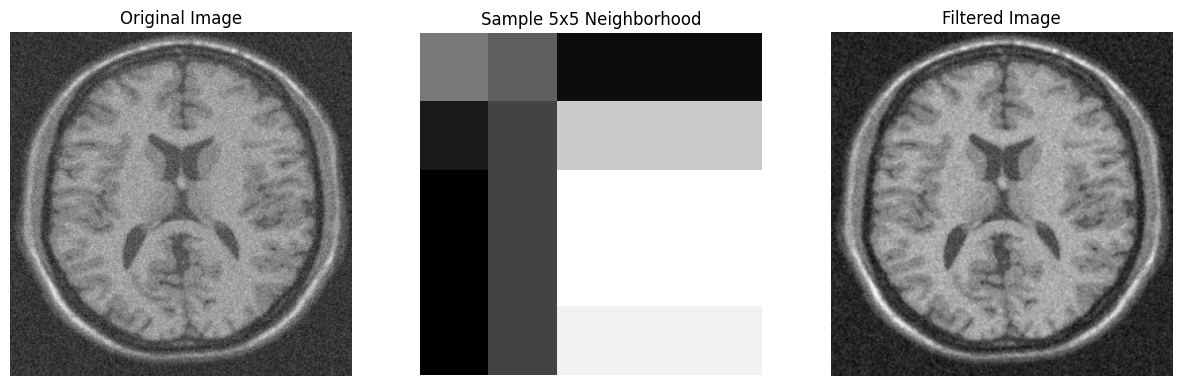

array([[75, 58, 43, ..., 40, 40, 40],
       [68, 58, 44, ..., 40, 38, 38],
       [59, 49, 44, ..., 39, 38, 38],
       ...,
       [57, 59, 59, ..., 51, 51, 51],
       [58, 58, 59, ..., 44, 46, 46],
       [58, 58, 58, ..., 43, 43, 43]], dtype=uint8)

In [42]:
def apply_median_filter(image, kernel_size=5):
    """
    Apply Median filter with visualization of the process
    """
    # Get sample neighborhood for visualization
    sample_x, sample_y = image.shape[0]//2, image.shape[1]//2
    print(sample_x,sample_y)
    neighborhood = image[sample_x-kernel_size//2:sample_x+kernel_size//2+1,
                       sample_y-kernel_size//2:sample_y+kernel_size//2+1]
    print(neighborhood)
    print(cv2.medianBlur(neighborhood, kernel_size))
    # Apply filter
    filtered_image = cv2.medianBlur(image, kernel_size)
    
    # Visualize process
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(neighborhood, cmap='gray')
    plt.title(f'Sample {kernel_size}x{kernel_size} Neighborhood')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    
    plt.show()
    
    return filtered_image


apply_median_filter(img, kernel_size=5)

In [37]:
r1 = np.array([[ 94,  92,  86,  86,  86],
 [ 87,  90, 100, 100, 100],
 [ 85,  90, 104, 104, 104],
 [ 85,  90, 104, 104, 104],
 [ 85,  90, 103, 103, 103]])
np.median(r1)

94.0

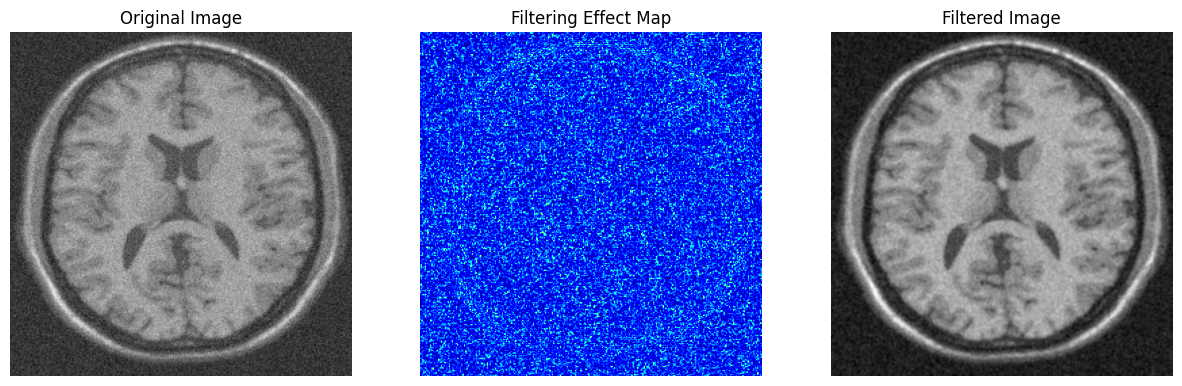

array([[52, 52, 52, ..., 41, 39, 39],
       [52, 51, 51, ..., 41, 40, 39],
       [51, 50, 50, ..., 43, 41, 41],
       ...,
       [59, 59, 59, ..., 53, 52, 52],
       [59, 59, 59, ..., 52, 51, 50],
       [59, 59, 59, ..., 51, 50, 50]], dtype=uint8)

In [43]:
def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    """
    Apply Bilateral filter with visualization of the process
    """
    # Apply filter
    filtered_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    
    # Calculate difference map for visualization
    difference = cv2.absdiff(image, filtered_image)
    
    # Visualize process
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(difference, cmap='jet')
    plt.title('Filtering Effect Map')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Filtered Image')
    plt.axis('off')
    
    plt.show()
    
    return filtered_image


    
apply_bilateral_filter(img, d=9, sigma_color=75, sigma_space=75)

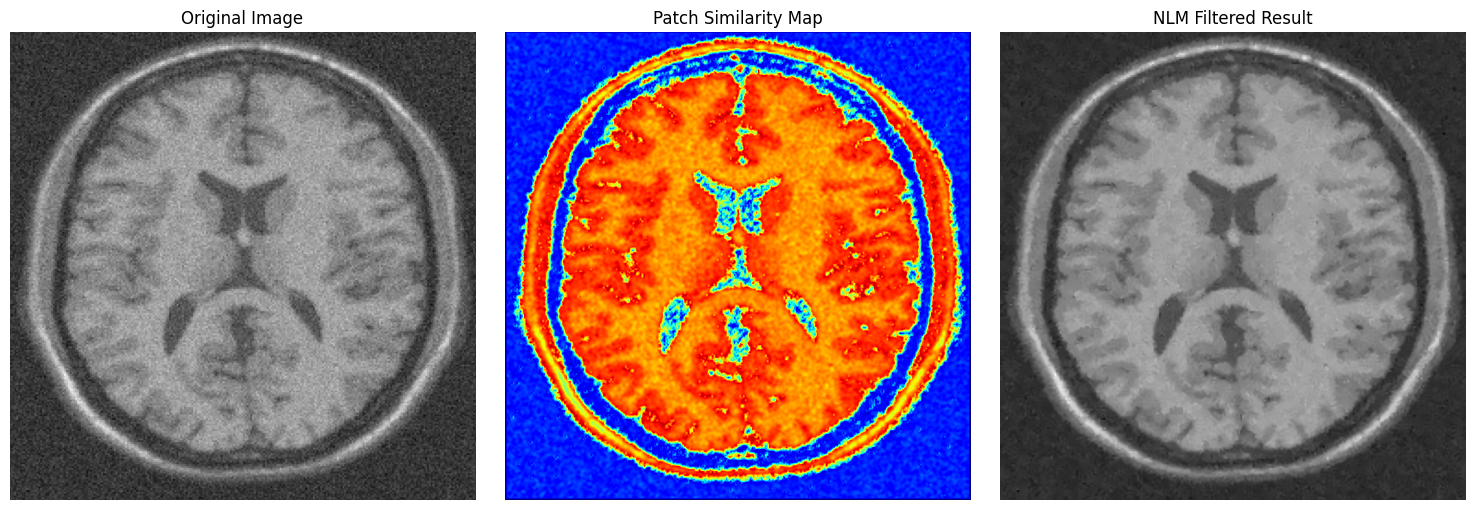

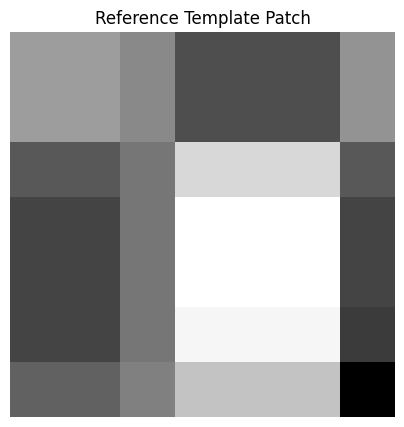

In [44]:
def apply_nlm_filter(image, h=10, template_window=7, search_window=21):
    """
    Apply Non-local Means filter with visualization of the process
    """
    # Apply filter
    filtered_image = cv2.fastNlMeansDenoising(
        image,
        None,
        h=h,
        templateWindowSize=template_window,
        searchWindowSize=search_window
    )
    
    # Calculate similarity map for visualization
    similarity_map = np.zeros_like(image, dtype=np.float32)
    sample_x, sample_y = image.shape[0]//2, image.shape[1]//2
    template = image[sample_x-template_window//2:sample_x+template_window//2+1,
                    sample_y-template_window//2:sample_y+template_window//2+1]
    
    for i in range(template_window//2, image.shape[0]-template_window//2):
        for j in range(template_window//2, image.shape[1]-template_window//2):
            patch = image[i-template_window//2:i+template_window//2+1,
                         j-template_window//2:j+template_window//2+1]
            similarity_map[i,j] = np.sum(np.abs(template - patch))
    
    similarity_map = cv2.normalize(similarity_map, None, 0, 1, cv2.NORM_MINMAX)
    
    # Visualize process
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(similarity_map, cmap='jet')
    plt.title('Patch Similarity Map')
    plt.axis('off')
    
    # Filtered result
    plt.subplot(133)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('NLM Filtered Result')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: show template patch
    plt.figure(figsize=(5, 5))
    plt.imshow(template, cmap='gray')
    plt.title('Reference Template Patch')
    plt.axis('off')
    plt.show()
apply_nlm_filter(img, h=10, template_window=7, search_window=21)